In [1]:
from paretoKnapsackTeams import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}"
    })
else:
    mpl.rcParams.update({"text.usetex": False})

#Import datasets
#IMDB
imdb_experts_1, imdb_tasks_1, imdb_costs_1, imdb_graphmat_1 = import_pickled_datasets('imdb', 1)
imdb_experts_2, imdb_tasks_2, imdb_costs_2, imdb_graphmat_2 = import_pickled_datasets('imdb', 2)
# imdb_experts_3, imdb_tasks_3, imdb_costs_3, imdb_graphmat_3 = import_pickled_datasets('imdb', 3)

#Bibsonomy
bbsm_experts_1, bbsm_tasks_1, bbsm_costs_1, bbsm_graphmat_1 = import_pickled_datasets('bbsm', 1)
# bbsm_experts_2, bbsm_tasks_2, bbsm_costs_2, bbsm_graphmat_2 = import_pickled_datasets('bbsm', 2)
# bbsm_experts_3, bbsm_tasks_3, bbsm_costs_3, bbsm_graphmat_3 = import_pickled_datasets('bbsm', 3)

#Freelancer
fl_experts_1, fl_tasks_1, fl_costs_1, fl_graphmat_1 = import_pickled_datasets('freelancer', 1)
# fl_experts_2, fl_tasks_2, fl_costs_2, fl_graphmat_2 = import_pickled_datasets('freelancer', 2)

2026-02-03 17:08:41,556 |INFO: Imported imdb experts, Num Experts: 200
2026-02-03 17:08:41,557 |INFO: Imported imdb tasks, Num Tasks: 300
2026-02-03 17:08:41,558 |INFO: Imported imdb costs, Num Costs: 200
2026-02-03 17:08:41,562 |INFO: Imported imdb graph matrix, Shape: (1000, 1000)

2026-02-03 17:08:41,563 |INFO: Imported imdb experts, Num Experts: 400
2026-02-03 17:08:41,564 |INFO: Imported imdb tasks, Num Tasks: 300
2026-02-03 17:08:41,565 |INFO: Imported imdb costs, Num Costs: 400
2026-02-03 17:08:41,572 |INFO: Imported imdb graph matrix, Shape: (3000, 3000)

2026-02-03 17:08:41,573 |INFO: Imported bbsm experts, Num Experts: 250
2026-02-03 17:08:41,574 |INFO: Imported bbsm tasks, Num Tasks: 300
2026-02-03 17:08:41,575 |INFO: Imported bbsm costs, Num Costs: 250
2026-02-03 17:08:41,577 |INFO: Imported bbsm graph matrix, Shape: (500, 500)

2026-02-03 17:08:41,578 |INFO: Imported freelancer experts, Num Experts: 50
2026-02-03 17:08:41,579 |INFO: Imported freelancer tasks, Num Tasks: 25

### Single Task Plotting

In [2]:
def findSingleTaskSolutions(tasks_list, experts_list, costs_list,
                             sizeUniverse, numExperts, maxBudget,
                             dataset_name=None, task_index=0, task_indices=None):
    '''
    Run algorithms for one or more single tasks and plot results (no averaging or interpolation).
    '''
    # Cost grid (same for all budgets within this task)
    num_steps, min_cost = 15, 5
    cost_arr = np.linspace(min_cost, maxBudget, num_steps)

    algo_names = ["PlainGreedy", "PlainGreedy-2Guess", "GreedyPlus-1Guess", "ParetoGreedy-Knapsack", "CoverageLinear", "TopK"]
    plot_algos = {
        "ParetoGreedy-Knapsack": True,
        "CoverageLinear": True,
        "PlainGreedy": True,
        "PlainGreedy-2Guess": True,
        "GreedyPlus-1Guess": True,
        "TopK": True
    }
    plot_algo_names = [alg for alg in algo_names if plot_algos.get(alg, False)]

    def sort_pairs(costs, covs):
        if len(costs) == 0:
            return np.array([]), np.array([])
        pairs = sorted(zip(costs, covs), key=lambda x: x[0])
        return np.array([p[0] for p in pairs], dtype=float), np.array([p[1] for p in pairs], dtype=float)

    def format_points(costs, covs):
        return [f"({c:.2f}, {v:.3f})" for c, v in zip(costs, covs)]

    # Determine which tasks to run
    if task_indices is None:
        task_indices = [task_index]
    task_indices = list(task_indices)
    num_tasks_total = len(tasks_list)
    task_indices = [i for i in task_indices if 0 <= i < num_tasks_total]
    if len(task_indices) == 0:
        raise ValueError("No valid task indices provided for this dataset.")

    # Plot settings
    colors = plt.get_cmap("tab10").colors
    marker_map = {
        "ParetoGreedy-Knapsack": "D",
        "CoverageLinear": "o",
        "PlainGreedy": "s",
        "PlainGreedy-2Guess": "^",
        "GreedyPlus-1Guess": "v",
        "TopK": "P"
    }
    marker_sizes = {"ParetoGreedy-Knapsack": 8, "CoverageLinear": 7, "PlainGreedy": 6, "PlainGreedy-2Guess": 6, "GreedyPlus-1Guess": 6, "TopK": 7}
    linestyle_map = {"ParetoGreedy-Knapsack": '-', "CoverageLinear": '-', "PlainGreedy": ':', "PlainGreedy-2Guess": '--', "GreedyPlus-1Guess": '-.', "TopK": ':'}
    zorder_map = {"ParetoGreedy-Knapsack": 6, "CoverageLinear": 5, "TopK": 4, "GreedyPlus-1Guess": 3, "PlainGreedy-2Guess": 2, "PlainGreedy": 1}
    alpha_map = {"ParetoGreedy-Knapsack": 1.0, "CoverageLinear": 0.95, "TopK": 0.9, "GreedyPlus-1Guess": 0.9, "PlainGreedy-2Guess": 0.9, "PlainGreedy": 0.9}
    mfc_map = {"ParetoGreedy-Knapsack": None, "CoverageLinear": "white", "TopK": "white", "GreedyPlus-1Guess": None, "PlainGreedy-2Guess": "white", "PlainGreedy": None}

    # Prepare figure with shared legend (2 rows x 3 columns)
    n_tasks = len(task_indices)
    n_rows, n_cols = 2, 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
    axes = np.array(axes).reshape(-1)
    legend_handles = None
    legend_labels = None

    # Per-dataset runtime summary
    runtime_totals = {alg: 0.0 for alg in algo_names}

    for ax_idx, task_idx in enumerate(task_indices):
        ax = axes[ax_idx]
        task = tasks_list[task_idx]

        # Prefix Pareto + Coverage Linear (computed once at full budget)
        paretoTeams_full = paretoKnapsackTeams(task=task,
                                          n_experts=experts_list[:numExperts],
                                          costs=costs_list, size_univ=sizeUniverse,
                                          budget=maxBudget)
        pp1_costs, pp1_coverages, pp1_map, pp1_time = paretoTeams_full.prefixParetoGreedy_1Guess()
        cl_costs, cl_coverages, cl_map, cl_time = paretoTeams_full.coverage_linear()

        # Per-budget results
        coverages = {alg: [] for alg in algo_names}
        runtimes = {alg: [] for alg in algo_names}

        for budgetVal in cost_arr:
            paretoTeams = paretoKnapsackTeams(task=task,
                                         n_experts=experts_list[:numExperts],
                                         costs=costs_list, size_univ=sizeUniverse,
                                         budget=budgetVal)

            # Plain Greedy
            plainExperts, _, plainCov, plainCost, plainTime = paretoTeams.plainGreedy()
            coverages['PlainGreedy'].append(plainCov)
            runtimes['PlainGreedy'].append(plainTime)

            # Two Guess Plain Greedy
            _, _, tgCov, tgCost, tgTime = paretoTeams.twoGuessPlainGreedy()
            coverages['PlainGreedy-2Guess'].append(tgCov)
            runtimes['PlainGreedy-2Guess'].append(tgTime)

            # One Guess Greedy Plus
            _, _, ogCov, ogCost, ogTime = paretoTeams.oneGuessGreedyPlus()
            coverages['GreedyPlus-1Guess'].append(ogCov)
            runtimes['GreedyPlus-1Guess'].append(ogTime)

            # Top-k (use #experts chosen by PlainGreedy)
            k_val = max(1, len(plainExperts))
            _, _, tkCov, tkCost, tkTime = paretoTeams.top_k(k_val)
            coverages['TopK'].append(tkCov)
            runtimes['TopK'].append(tkTime)

        runtimes['ParetoGreedy-Knapsack'].append(pp1_time)
        runtimes['CoverageLinear'].append(cl_time)

        # Log pareto points per algorithm
        pg_costs, pg_covs = sort_pairs(pp1_costs, pp1_coverages)
        cl_costs_sorted, cl_covs_sorted = sort_pairs(cl_costs, cl_coverages)
        logging.info("Task %d pareto points - ParetoGreedy-Knapsack: %s", task_idx, format_points(pg_costs, pg_covs))
        logging.info("Task %d pareto points - CoverageLinear: %s", task_idx, format_points(cl_costs_sorted, cl_covs_sorted))
        logging.info("Task %d pareto points - PlainGreedy: %s", task_idx, format_points(cost_arr, coverages['PlainGreedy']))
        logging.info("Task %d pareto points - PlainGreedy-2Guess: %s", task_idx, format_points(cost_arr, coverages['PlainGreedy-2Guess']))
        logging.info("Task %d pareto points - GreedyPlus-1Guess: %s", task_idx, format_points(cost_arr, coverages['GreedyPlus-1Guess']))
        logging.info("Task %d pareto points - TopK: %s", task_idx, format_points(cost_arr, coverages['TopK']))

        series_map = {
            "ParetoGreedy-Knapsack": sort_pairs(pp1_costs, pp1_coverages),
            "CoverageLinear": sort_pairs(cl_costs, cl_coverages),
            "PlainGreedy": (cost_arr, np.array(coverages['PlainGreedy'], dtype=float)),
            "PlainGreedy-2Guess": (cost_arr, np.array(coverages['PlainGreedy-2Guess'], dtype=float)),
            "GreedyPlus-1Guess": (cost_arr, np.array(coverages['GreedyPlus-1Guess'], dtype=float)),
            "TopK": (cost_arr, np.array(coverages['TopK'], dtype=float))
        }

        for i, alg in enumerate(plot_algo_names):
            color = colors[i % len(colors)]
            marker = marker_map.get(alg, 'o')
            label = rf"\texttt{{{alg}}}"
            x_vals, y_vals = series_map[alg]
            ax.plot(x_vals, y_vals,
                    label=(label if ax_idx == 0 else "_nolegend_"),
                    color=color,
                    linestyle=linestyle_map.get(alg, ':'),
                    marker=marker,
                    markersize=marker_sizes.get(alg, 6),
                    markeredgewidth=1.2,
                    markeredgecolor='k',
                    markerfacecolor=(mfc_map.get(alg) if mfc_map.get(alg) is not None else color),
                    linewidth=1.8,
                    alpha=alpha_map.get(alg, 0.9),
                    zorder=zorder_map.get(alg, 1))

        ax.set_title("")
        ax.grid(alpha=0.3)
        ax.tick_params(axis='both', labelsize=24)

        if ax_idx == 0:
            legend_handles, legend_labels = ax.get_legend_handles_labels()

        # Runtime summary for this task
        for alg in algo_names:
            total_runtime = float(np.nansum(np.array(runtimes.get(alg, []), dtype=float)))
            runtime_totals[alg] += total_runtime

    # Hide unused subplots if any
    for ax in axes[n_tasks:]:
        ax.axis('off')

    if legend_handles is not None:
        fig.legend(legend_handles, legend_labels, loc='upper center', ncol=3, fontsize=20, frameon=False)

    for r in range(n_rows):
        for c in range(n_cols):
            idx = r * n_cols + c
            if idx >= len(axes):
                continue
            ax = axes[idx]
            if r == n_rows - 1:
                ax.set_xlabel(r'Team cost ($c_\ell$)', fontsize=24)
            if c == 0:
                ax.set_ylabel(r'Task coverage ($f$)', fontsize=24)

    fig.tight_layout(rect=[0.03, 0.03, 1, 0.9])

    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "knapsack" / "single"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_knapsack_single_task.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    plt.show()

    # Runtime summary (seconds)
    runtime_lines = ["Runtime summary (seconds):"]
    for alg in algo_names:
        runtime_lines.append(f"  - {alg}: {runtime_totals[alg]:.3f}")
    logging.info("\n".join(runtime_lines))

## Freelancer-1

2026-02-03 17:08:44,204 |INFO: Task 0 pareto points - ParetoGreedy-Knapsack: ['(20.00, 0.250)', '(45.00, 0.500)', '(70.00, 0.750)', '(120.00, 1.000)']
2026-02-03 17:08:44,205 |INFO: Task 0 pareto points - CoverageLinear: ['(20.00, 0.250)', '(45.00, 0.500)', '(90.00, 0.750)', '(140.00, 1.000)']
2026-02-03 17:08:44,205 |INFO: Task 0 pareto points - PlainGreedy: ['(5.00, 0.000)', '(40.36, 0.250)', '(75.71, 0.500)', '(111.07, 0.750)', '(146.43, 1.000)', '(181.79, 1.000)', '(217.14, 1.000)', '(252.50, 1.000)', '(287.86, 1.000)', '(323.21, 1.000)', '(358.57, 1.000)', '(393.93, 1.000)', '(429.29, 1.000)', '(464.64, 1.000)', '(500.00, 1.000)']
2026-02-03 17:08:44,206 |INFO: Task 0 pareto points - PlainGreedy-2Guess: ['(5.00, 0.000)', '(40.36, 0.250)', '(75.71, 0.750)', '(111.07, 0.750)', '(146.43, 1.000)', '(181.79, 1.000)', '(217.14, 1.000)', '(252.50, 1.000)', '(287.86, 1.000)', '(323.21, 1.000)', '(358.57, 1.000)', '(393.93, 1.000)', '(429.29, 1.000)', '(464.64, 1.000)', '(500.00, 1.000)']


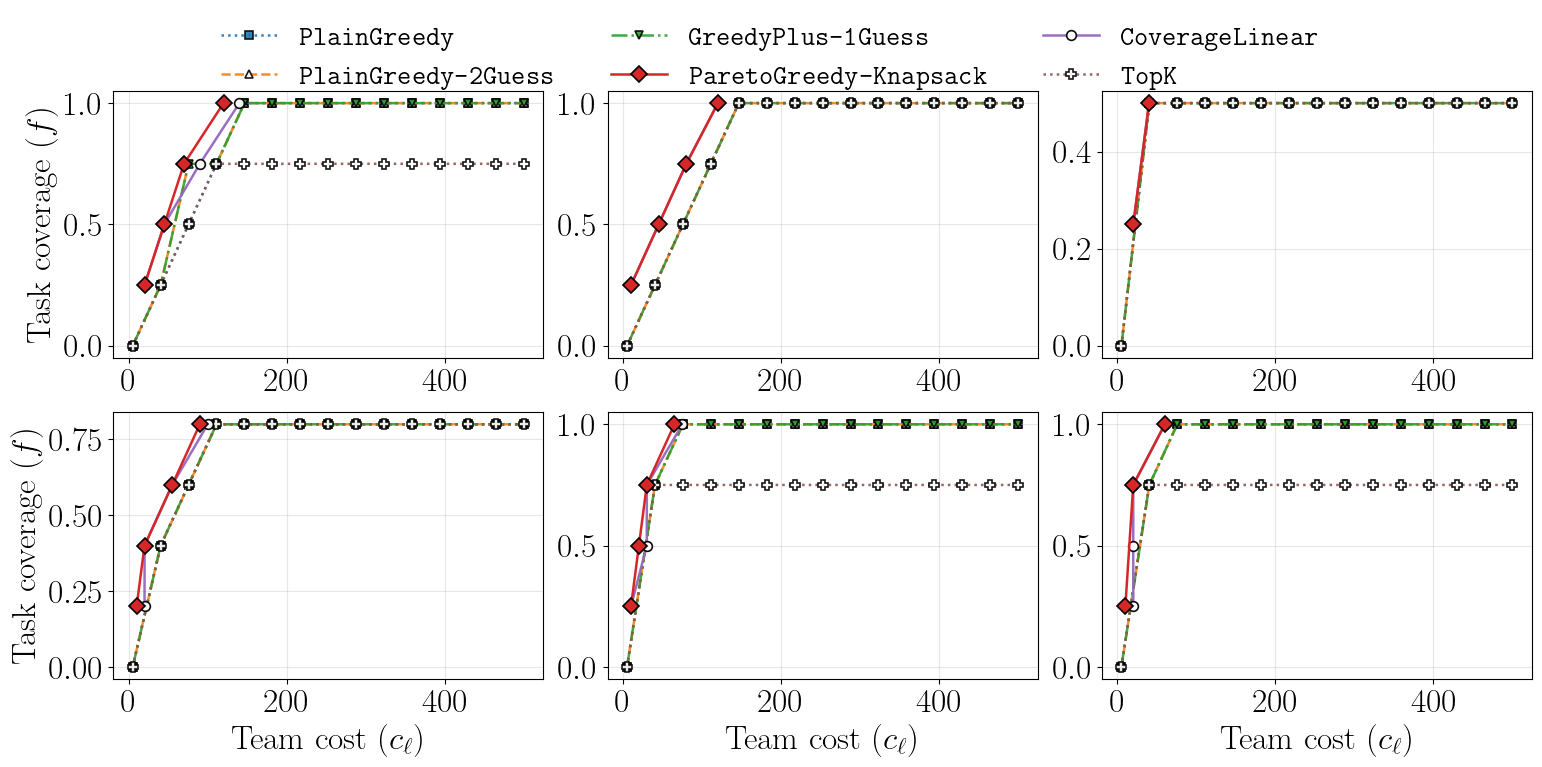

2026-02-03 17:09:01,417 |INFO: Runtime summary (seconds):
  - PlainGreedy: 0.017
  - PlainGreedy-2Guess: 15.726
  - GreedyPlus-1Guess: 1.912
  - ParetoGreedy-Knapsack: 0.066
  - CoverageLinear: 0.003
  - TopK: 0.006


In [3]:
findSingleTaskSolutions(tasks_list=fl_tasks_1, experts_list=fl_experts_1, costs_list=fl_costs_1,
                        sizeUniverse=50, numExperts=50, maxBudget=500,
                        dataset_name="Freelancer", task_indices=range(6))

## IMDB

2026-02-03 17:09:10,858 |INFO: Task 0 pareto points - ParetoGreedy-Knapsack: ['(5.00, 0.625)', '(10.00, 0.750)', '(20.00, 0.875)', '(40.00, 1.000)']
2026-02-03 17:09:10,859 |INFO: Task 0 pareto points - CoverageLinear: ['(5.00, 0.125)', '(5.00, 0.250)', '(5.00, 0.375)', '(5.00, 0.500)', '(5.00, 0.625)', '(10.00, 0.750)', '(25.00, 0.875)', '(45.00, 1.000)']
2026-02-03 17:09:10,860 |INFO: Task 0 pareto points - PlainGreedy: ['(5.00, 0.625)', '(13.21, 0.750)', '(21.43, 0.750)', '(29.64, 0.875)', '(37.86, 0.875)', '(46.07, 1.000)', '(54.29, 1.000)', '(62.50, 1.000)', '(70.71, 1.000)', '(78.93, 1.000)', '(87.14, 1.000)', '(95.36, 1.000)', '(103.57, 1.000)', '(111.79, 1.000)', '(120.00, 1.000)']
2026-02-03 17:09:10,860 |INFO: Task 0 pareto points - PlainGreedy-2Guess: ['(5.00, 0.625)', '(13.21, 0.750)', '(21.43, 0.875)', '(29.64, 0.875)', '(37.86, 0.875)', '(46.07, 1.000)', '(54.29, 1.000)', '(62.50, 1.000)', '(70.71, 1.000)', '(78.93, 1.000)', '(87.14, 1.000)', '(95.36, 1.000)', '(103.57, 1

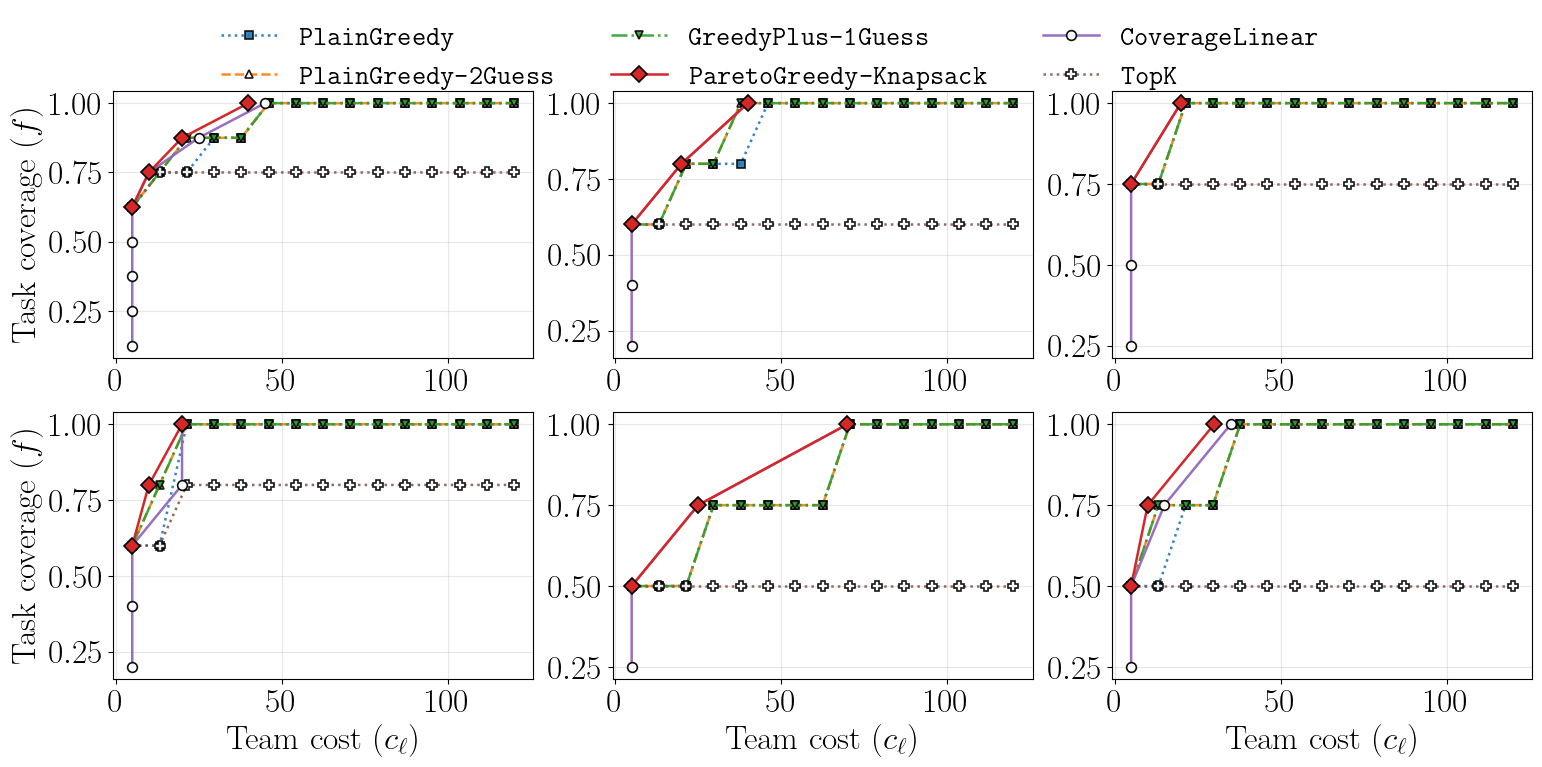

2026-02-03 17:09:46,766 |INFO: Runtime summary (seconds):
  - PlainGreedy: 0.074
  - PlainGreedy-2Guess: 39.335
  - GreedyPlus-1Guess: 4.108
  - ParetoGreedy-Knapsack: 0.417
  - CoverageLinear: 0.011
  - TopK: 0.012


In [4]:
findSingleTaskSolutions(tasks_list=imdb_tasks_1, experts_list=imdb_experts_1, costs_list=imdb_costs_1,
                        sizeUniverse=24, numExperts=150, maxBudget=120,
                        dataset_name="IMDB-1", task_indices=range(6))

2026-02-03 17:10:06,640 |INFO: Task 0 pareto points - ParetoGreedy-Knapsack: ['(5.00, 0.444)', '(10.00, 0.667)', '(15.00, 0.778)', '(20.00, 1.000)']
2026-02-03 17:10:06,642 |INFO: Task 0 pareto points - CoverageLinear: ['(5.00, 0.111)', '(5.00, 0.222)', '(5.00, 0.333)', '(5.00, 0.444)', '(10.00, 0.556)', '(10.00, 0.667)', '(15.00, 0.778)', '(20.00, 0.889)', '(25.00, 1.000)']
2026-02-03 17:10:06,644 |INFO: Task 0 pareto points - PlainGreedy: ['(5.00, 0.444)', '(10.36, 0.667)', '(15.71, 0.778)', '(21.07, 0.889)', '(26.43, 1.000)', '(31.79, 1.000)', '(37.14, 1.000)', '(42.50, 1.000)', '(47.86, 1.000)', '(53.21, 1.000)', '(58.57, 1.000)', '(63.93, 1.000)', '(69.29, 1.000)', '(74.64, 1.000)', '(80.00, 1.000)']
2026-02-03 17:10:06,645 |INFO: Task 0 pareto points - PlainGreedy-2Guess: ['(5.00, 0.444)', '(10.36, 0.667)', '(15.71, 0.778)', '(21.07, 1.000)', '(26.43, 1.000)', '(31.79, 1.000)', '(37.14, 1.000)', '(42.50, 1.000)', '(47.86, 1.000)', '(53.21, 1.000)', '(58.57, 1.000)', '(63.93, 1.00

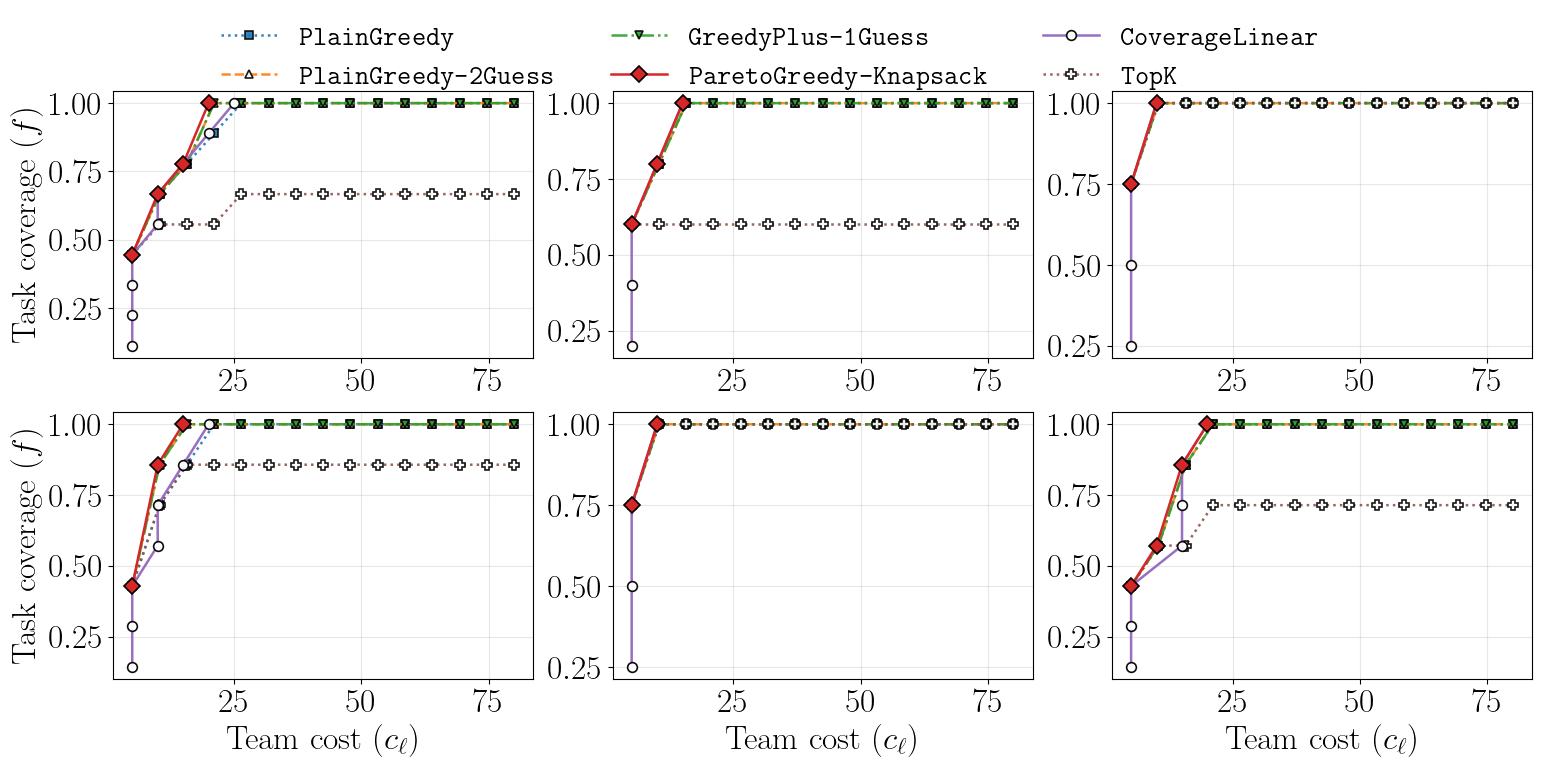

2026-02-03 17:11:21,490 |INFO: Runtime summary (seconds):
  - PlainGreedy: 0.081
  - PlainGreedy-2Guess: 85.106
  - GreedyPlus-1Guess: 7.462
  - ParetoGreedy-Knapsack: 0.679
  - CoverageLinear: 0.023
  - TopK: 0.017


In [5]:
findSingleTaskSolutions(tasks_list=imdb_tasks_2, experts_list=imdb_experts_2, costs_list=imdb_costs_2,
                        sizeUniverse=24, numExperts=300, maxBudget=80,
                        dataset_name="IMDB-2", task_indices=range(6))

## Bbsm-1

2026-02-03 17:11:35,825 |INFO: Task 0 pareto points - ParetoGreedy-Knapsack: ['(5.00, 0.500)', '(10.00, 0.750)', '(20.00, 1.000)']
2026-02-03 17:11:35,826 |INFO: Task 0 pareto points - CoverageLinear: ['(5.00, 0.250)', '(5.00, 0.500)', '(15.00, 0.750)', '(25.00, 1.000)']
2026-02-03 17:11:35,826 |INFO: Task 0 pareto points - PlainGreedy: ['(5.00, 0.500)', '(10.00, 0.500)', '(15.00, 0.750)', '(20.00, 0.750)', '(25.00, 1.000)', '(30.00, 1.000)', '(35.00, 1.000)', '(40.00, 1.000)', '(45.00, 1.000)', '(50.00, 1.000)', '(55.00, 1.000)', '(60.00, 1.000)', '(65.00, 1.000)', '(70.00, 1.000)', '(75.00, 1.000)']
2026-02-03 17:11:35,827 |INFO: Task 0 pareto points - PlainGreedy-2Guess: ['(5.00, 0.500)', '(10.00, 0.750)', '(15.00, 0.750)', '(20.00, 1.000)', '(25.00, 1.000)', '(30.00, 1.000)', '(35.00, 1.000)', '(40.00, 1.000)', '(45.00, 1.000)', '(50.00, 1.000)', '(55.00, 1.000)', '(60.00, 1.000)', '(65.00, 1.000)', '(70.00, 1.000)', '(75.00, 1.000)']
2026-02-03 17:11:35,828 |INFO: Task 0 pareto po

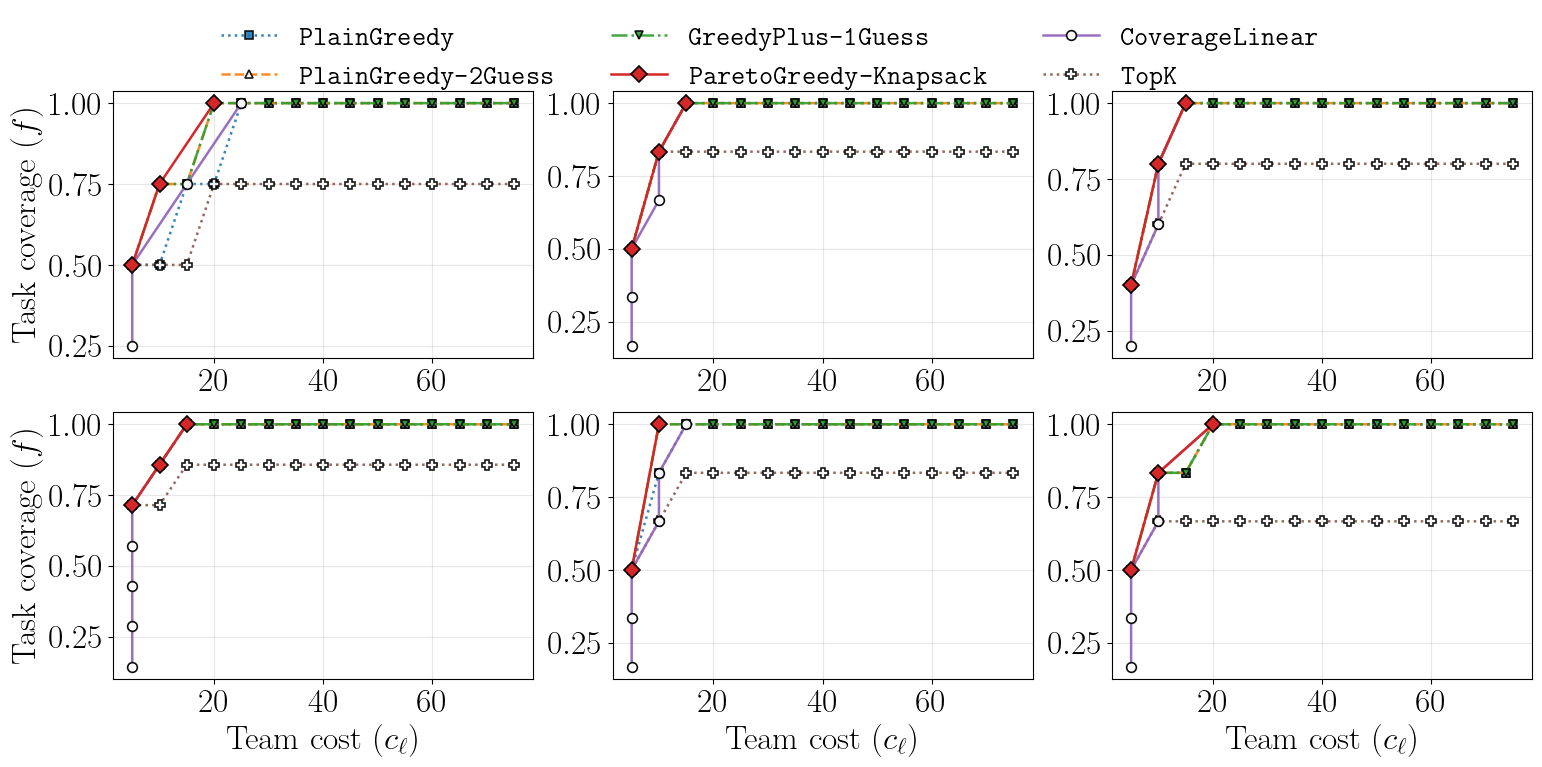

2026-02-03 17:12:46,066 |INFO: Runtime summary (seconds):
  - PlainGreedy: 0.084
  - PlainGreedy-2Guess: 74.717
  - GreedyPlus-1Guess: 7.742
  - ParetoGreedy-Knapsack: 0.628
  - CoverageLinear: 0.019
  - TopK: 0.017


In [6]:
findSingleTaskSolutions(tasks_list=bbsm_tasks_1, experts_list=bbsm_experts_1, costs_list=bbsm_costs_1,
                        sizeUniverse=75, numExperts=250, maxBudget=75,
                        dataset_name="Bbsm", task_indices=range(6))